In [1]:
# 2️⃣ Kütüphaneler
import os
import pandas as pd
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
import matplotlib.pyplot as plt
from getpass import getpass

In [2]:
# 3️⃣ OpenAI API Key
os.environ["OPENAI_API_KEY"] = ''

# 4️⃣ CSV dosyalarını oku ve birleştir
csv_folder = "sales_csvs"  # CSV dosyalarının klasörü
all_text = ""
for file in os.listdir(csv_folder):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(csv_folder, file))
        # Metin formatına çevir
        csv_text = "\n".join(
            [f"Tarih: {row['Date']}, Ürün: {row['Product']}, Satış Adedi: {row['Quantity']}, Gelir: {row['Revenue']}"
             for idx, row in df.iterrows()]
        )
        all_text += f"--- {file} ---\n{csv_text}\n\n"

print("✅ Tüm CSV dosyaları metin formatına dönüştürüldü.")

✅ Tüm CSV dosyaları metin formatına dönüştürüldü.


In [3]:
# 5️⃣ Vektör veritabanı oluştur
embeddings = OpenAIEmbeddings()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_text(all_text)
db = Chroma.from_texts(chunks, embeddings)
retriever = db.as_retriever()

# 6️⃣ LLM + RAG zinciri
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.2)  # ucuz ve hızlı model
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever
)

/tmp/ipython-input-366618446.py:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings()


In [6]:
# 7️⃣ Otomatik rapor üret
report_prompt = (
    "Elimdeki satış verilerini analiz et ve şunları içeren bir rapor hazırla:\n"
    "- Toplam satış adedi ve toplam gelir\n"
    "- En çok ve en az satılan ürünler\n"
    "- Ürün bazlı gelir ve satış trendleri\n"
    "- Kısa özet ve tavsiyeler"
)

report = qa_chain.run(report_prompt)

# 8️⃣ Raporu dosyaya kaydet
output_file = "sales_auto_report.txt"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(report)

print(f"✅ Otomatik rapor '{output_file}' dosyasına kaydedildi.\n")
print("💡 Raporun önizlemesi:\n")
print(report[:1000], "...")  # İlk 1000 karakter önizleme


✅ Otomatik rapor 'sales_auto_report.txt' dosyasına kaydedildi.

💡 Raporun önizlemesi:

Rapor:

- Toplam satış adedi: 549
- Toplam gelir: 20537

- En çok satılan ürün: Widget A (Toplam satış adedi: 170)
- En az satılan ürün: Widget E (Toplam satış adedi: 106)

- Ürün bazlı gelir ve satış trendleri:
  - Widget A: Toplam gelir: 6171, Toplam satış adedi: 170
  - Widget B: Toplam gelir: 3117, Toplam satış adedi: 76
  - Widget C: Toplam gelir: 1980, Toplam satış adedi: 84
  - Widget D: Toplam gelir: 3067, Toplam satış adedi: 93
  - Widget E: Toplam gelir: 6202, Toplam satış adedi: 126

- Kısa özet ve tavsiyeler:
  - Widget A en çok satılan ürün olmasına rağmen, gelir bazında Widget E daha fazla kazanç sağlamıştır. Widget A'nın satış adedini artırmak ve gelirini optimize etmek için pazarlama stratejileri geliştirilebilir.
  - Widget B'nin satış adedi diğer ürünlere göre düşük olmasına rağmen, gelir bazında iyi performans göstermiştir. Bu ürünün pazar payını artırmak için farklı satış kanallar

In [8]:
df_all = pd.DataFrame()

for file in os.listdir(csv_folder):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(csv_folder, file))
        df_all = pd.concat([df_all, df], ignore_index=True)


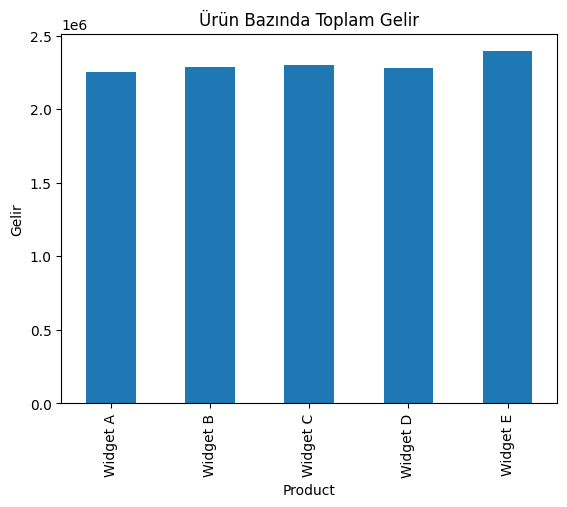

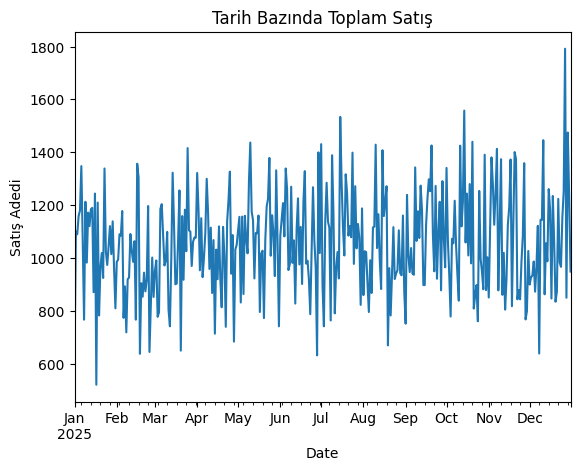

In [9]:
# 9️⃣ Ürün bazında toplam gelir grafiği
revenue_by_product = df_all.groupby("Product")["Revenue"].sum()
revenue_by_product.plot(kind="bar", title="Ürün Bazında Toplam Gelir")
plt.ylabel("Gelir")
plt.show()

# 10️⃣ Tarih bazında toplam satış grafiği
df_all['Date'] = pd.to_datetime(df_all['Date'])
sales_by_date = df_all.groupby('Date')["Quantity"].sum()
sales_by_date.plot(kind="line", title="Tarih Bazında Toplam Satış")
plt.ylabel("Satış Adedi")
plt.show()